In [1]:
import os.path as osp
import os
from typing import Optional

import torch
import torch.nn as nn
from torch import Tensor

from torch_geometric.datasets import ZINC
from torch_geometric.loader import DataLoader
from torch_geometric.nn import TokenGT
from torch_geometric.transforms import AddOrthonormalNodeIdentifiers

import numpy as np
import wandb
import random

In [2]:

class TokenGTGraphRegression(nn.Module):
    def __init__(
        self,
        dim_node,
        d_p,
        d,
        num_heads,
        num_encoder_layers,
        dim_feedforward,
        include_graph_token,
        is_laplacian_node_ids,
        dim_edge,
        dropout,
        device,
    ):
        super().__init__()
        self._token_gt = TokenGT(
            dim_node=dim_node,
            dim_edge=dim_edge,
            d_p=d_p,
            d=d,
            num_heads=num_heads,
            num_encoder_layers=num_encoder_layers,
            dim_feedforward=dim_feedforward,
            is_laplacian_node_ids=is_laplacian_node_ids,
            include_graph_token=include_graph_token,
            dropout=dropout,
            device=device,
        )
        self.lm = nn.Linear(d, 1, device=device)

    def forward(self, batch):
        # batch.edge_index = None
        # batch.edge_attr = None
        _, graph_emb = self._token_gt(batch.x.float(),
                                      batch.edge_index,
                                      batch.edge_attr.unsqueeze(1).float(),
                                    #   torch.empty(2, 0),
                                    #   None,
                                      batch.ptr,
                                      batch.batch,
                                      batch.node_ids)
        return self.lm(graph_emb)


def train(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    for batch in loader:
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += loss
    return total_loss / len(loader.dataset)


def get_loss(model, loader, criterion) -> float:
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch in loader:
            out = model(batch)
            loss = criterion(out, batch.y.unsqueeze(1)).item()
            total_loss += loss
    return total_loss / len(loader.dataset)

In [3]:

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True


config = {
    "architecture": "TokenGT",
    "dataset": "ZINC_12K",
    "D_P": 64,
    # "head_dim": 4,
    "num_heads": 16,
    "d": 64,
    "num_encoder_layers": 4,
    "dim_feedforward": 64,
    "include_graph_token": True,
    "use_laplacian": False,
    "dropout": 0.1,
    "epochs": 1,
    "lr": 0.001,
    "train_batch_size": 32,
}

run = wandb.init(
    entity="krecharles-university-of-oxford",
    project="TokenGT",
    config=config,
    mode="disabled"
)

config = wandb.config

transform = AddOrthonormalNodeIdentifiers(
    config.D_P, config.use_laplacian)
path = osp.join(osp.realpath(os.getcwd()),
                "data", f"ZINC-ort-{config.D_P}")
# note: use pre_transform (avoid unnecessary duplicate eigenvector calculation)
train_dataset = ZINC(path, subset=True, split="train",
                        pre_transform=transform)
val_dataset = ZINC(path, subset=True, split="val", pre_transform=transform)

if torch.cuda.is_available():
    train_dataset.cuda()
    val_dataset.cuda()

train_loader = DataLoader(
    train_dataset, batch_size=config.train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TokenGTGraphRegression(
    dim_node=train_dataset.num_node_features,
    dim_edge=train_dataset.num_edge_features,
    d_p=config.D_P,
    d=config.d,
    num_heads=config.num_heads,
    num_encoder_layers=config.num_encoder_layers,
    dim_feedforward=config.dim_feedforward,
    include_graph_token=config.include_graph_token,
    is_laplacian_node_ids=config.use_laplacian,
    dropout=config.dropout,
    device=device,
)
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of params: {num_params}")
run.log({"num_param": num_params})

criterion = nn.L1Loss(reduction="sum")
optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr)

train_loss = get_loss(model, train_loader, criterion)
val_loss = get_loss(model, val_loader, criterion)
print(f"Epoch 0: train_loss={train_loss:.5f} val_loss={val_loss:.5f}")
run.log({"train_loss": train_loss, "val_loss": val_loss}, step=1)

for i in range(2, config.epochs + 2):
    train_loss = train(model, train_loader, criterion, optimizer)
    val_loss = get_loss(model, val_loader, criterion)
    print(f"Epoch {i}: train_loss={train_loss:.5f} val_loss={val_loss:.5f}")
    run.log({"train_loss": train_loss, "val_loss": val_loss}, step=i)

run.finish()

/opt/anaconda3/envs/tokengt_env/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Number of params: 109441
Epoch 0: train_loss=1.49331 val_loss=1.46119
Epoch 2: train_loss=1.22305 val_loss=1.39135


Found graph with cycle at index 792
Number of cycles: 2
Cycle lengths: [5, 6]
Ground truth (penalized logP): 1.3393
Found graph without cycle at index 998
Ground truth (penalized logP): 0.0098


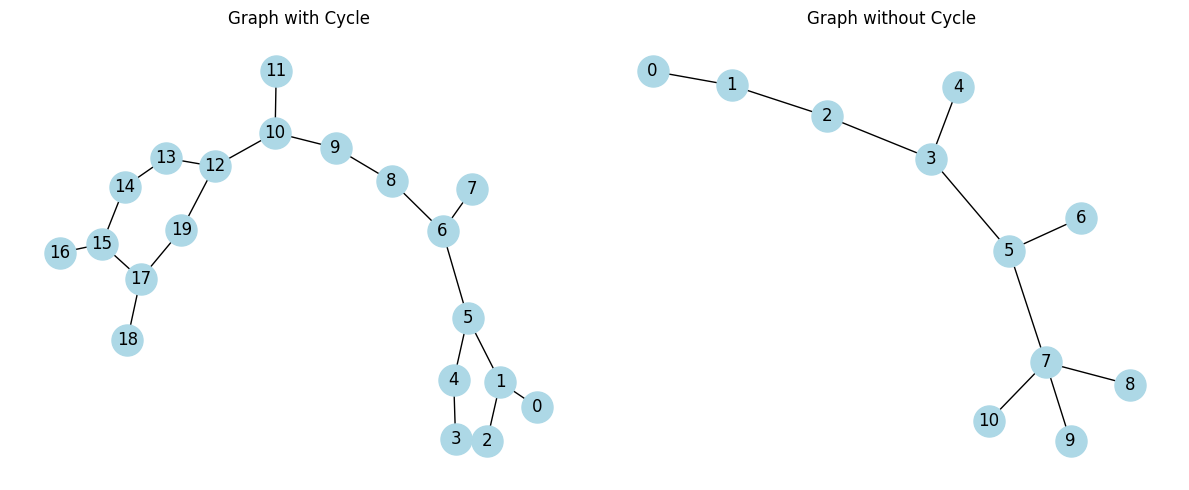

In [4]:
from torch_geometric.utils.convert import to_networkx
import networkx as nx
import matplotlib.pyplot as plt


def find_test_graphs(val_dataset, seed=42):
    # Set random seeds for reproducibility
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Shuffle the dataset indices
    indices = list(range(len(val_dataset)))
    random.shuffle(indices)
    
    cycle_graph = None
    non_cycle_graph = None
    for i in indices:
        # Convert to networkx graph
        G = to_networkx(val_dataset[i], to_undirected=True)
        
        # Check if graph has cycles
        cycles = list(nx.simple_cycles(G))
        
        if cycles and cycle_graph is None:
            cycle_graph = (val_dataset[i], G, cycles)
            print(f"Found graph with cycle at index {i}")
            print(f"Number of cycles: {len(cycles)}")
            print(f"Cycle lengths: {[len(c) for c in cycles]}")
            print(f"Ground truth (penalized logP): {val_dataset[i].y.item():.4f}")
            
        elif not cycles and non_cycle_graph is None:
            non_cycle_graph = (val_dataset[i], G)
            print(f"Found graph without cycle at index {i}")
            print(f"Ground truth (penalized logP): {val_dataset[i].y.item():.4f}")
            
        if cycle_graph and non_cycle_graph:
            break
    
    return cycle_graph, non_cycle_graph

def visualize_graphs(cycle_graph, non_cycle_graph):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot graph with cycle
    data, G, cycles = cycle_graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', 
            node_size=500, ax=ax1)
    ax1.set_title('Graph with Cycle')
    
    # Plot graph without cycle
    data, G = non_cycle_graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', 
            node_size=500, ax=ax2)
    ax2.set_title('Graph without Cycle')
    
    plt.tight_layout()
    plt.show()


cycle_graph, non_cycle_graph = find_test_graphs(val_dataset, seed=40)
visualize_graphs(cycle_graph, non_cycle_graph)





In [5]:
def evaluate_model_on_graphs(model, cycle_graph, non_cycle_graph):
    model.eval()
    with torch.no_grad():
        # Create DataLoader for each graph
        cycle_data, _, _ = cycle_graph
        non_cycle_data, _ = non_cycle_graph
        
        # Create single-item batches
        cycle_loader = DataLoader([cycle_data], batch_size=1)
        non_cycle_loader = DataLoader([non_cycle_data], batch_size=1)
        
        # Evaluate graph with cycle
        cycle_batch = next(iter(cycle_loader)).to(device)
        cycle_out = model(cycle_batch)
        cycle_emb = cycle_out.detach().cpu().numpy()
        cycle_gt = cycle_data.y.item()
        
        # Evaluate graph without cycle
        non_cycle_batch = next(iter(non_cycle_loader)).to(device)
        non_cycle_out = model(non_cycle_batch)
        non_cycle_emb = non_cycle_out.detach().cpu().numpy()
        non_cycle_gt = non_cycle_data.y.item()

        print(f"Cycle graph:")
        print(f"  - Model prediction: {cycle_emb[0][0]:.4f}")
        print(f"  - Ground truth: {cycle_gt:.4f}")
        print(f"\nNon-cycle graph:")
        print(f"  - Model prediction: {non_cycle_emb[0][0]:.4f}")
        print(f"  - Ground truth: {non_cycle_gt:.4f}")

evaluate_model_on_graphs(model, cycle_graph, non_cycle_graph)

Cycle graph:
  - Model prediction: 1.5628
  - Ground truth: 1.3393

Non-cycle graph:
  - Model prediction: 0.5608
  - Ground truth: 0.0098


In [6]:
from collections import defaultdict


model.eval()

# Initialize containers for results
cycle_results = defaultdict(list)
non_cycle_results = defaultdict(list)

# Create DataLoader for evaluation

val_cycle_dataset = []
val_non_cycle_dataset = []

with torch.no_grad():
    for i in range(len(val_dataset)):

        # Get the graph data
        graph_data = val_dataset[i]
        G = to_networkx(graph_data, to_undirected=True)

        # Check if graph has cycles
        has_cycles = len(list(nx.simple_cycles(G))) > 0

        if has_cycles:
            val_cycle_dataset.append(graph_data)
        else:
            val_non_cycle_dataset.append(graph_data)

val_cycle_loader = DataLoader(val_cycle_dataset, batch_size=1)
val_non_cycle_loader = DataLoader(val_non_cycle_dataset, batch_size=1)

cycle_loss = get_loss(model, val_cycle_loader, criterion)
non_cycle_loss = get_loss(model, val_non_cycle_loader, criterion)

num_cycle_graphs = len(val_cycle_dataset)
num_non_cycle_graphs = len(val_non_cycle_dataset)
print(f"Cycle loss: {cycle_loss}")
print(f"Non-cycle loss: {non_cycle_loss}")
print(f"Number of cycle graphs: {num_cycle_graphs}")
print(f"Number of non-cycle graphs: {num_non_cycle_graphs}")


Cycle loss: 1.3921881585463032
Non-cycle loss: 0.5509501099586487
Number of cycle graphs: 999
Number of non-cycle graphs: 1


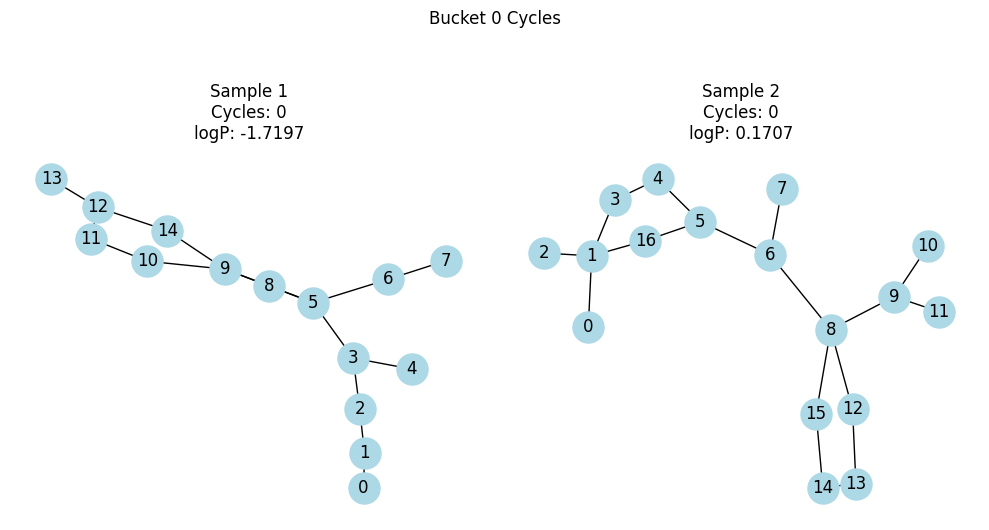


Bucket 0:
Number of graphs: 56
Average logP: -1.1830
--------------------------------------------------


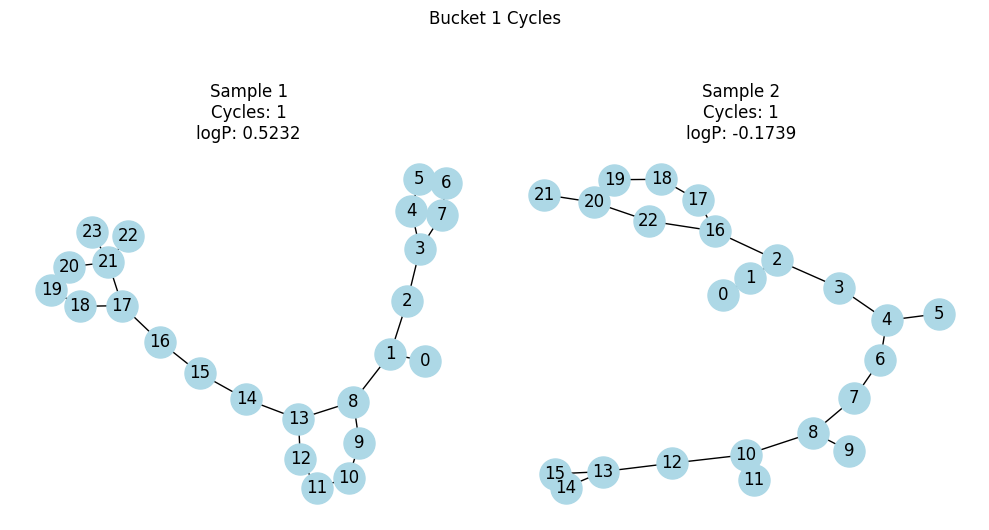


Bucket 1:
Number of graphs: 280
Average logP: -0.3277
--------------------------------------------------


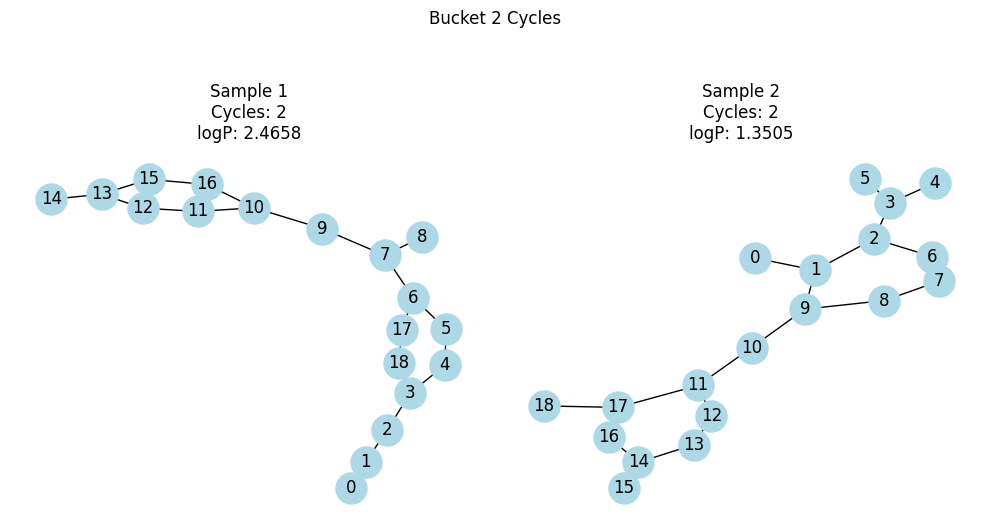


Bucket 2:
Number of graphs: 327
Average logP: 0.3920
--------------------------------------------------


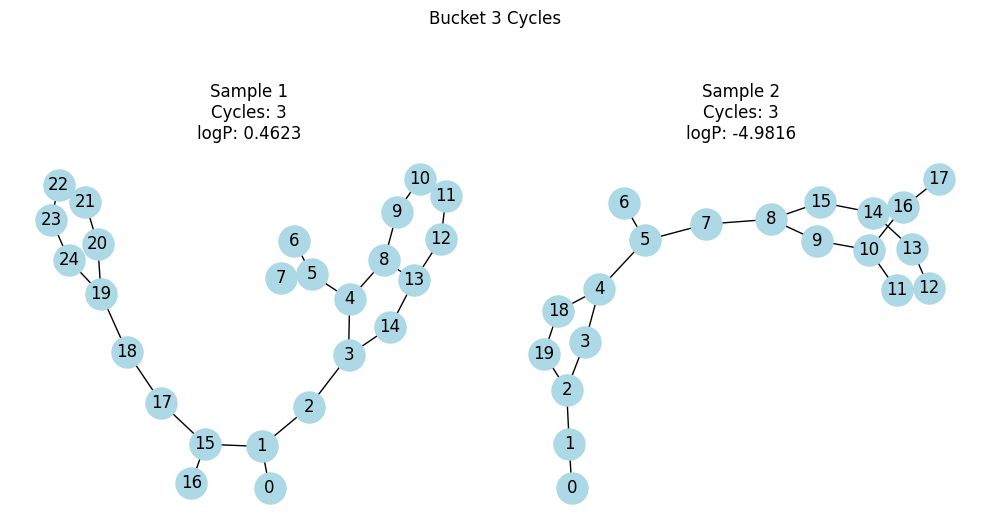


Bucket 3:
Number of graphs: 185
Average logP: 0.4448
--------------------------------------------------


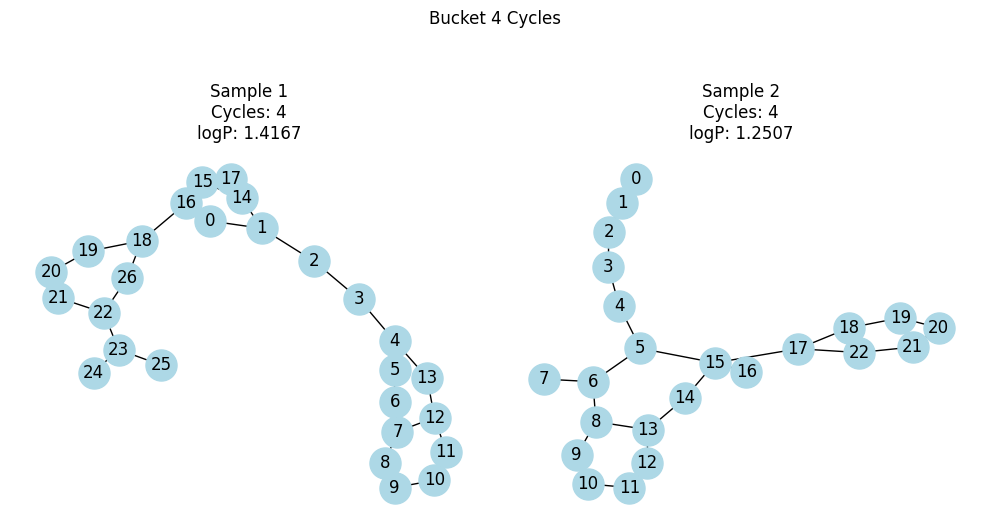


Bucket 4:
Number of graphs: 83
Average logP: 0.2260
--------------------------------------------------


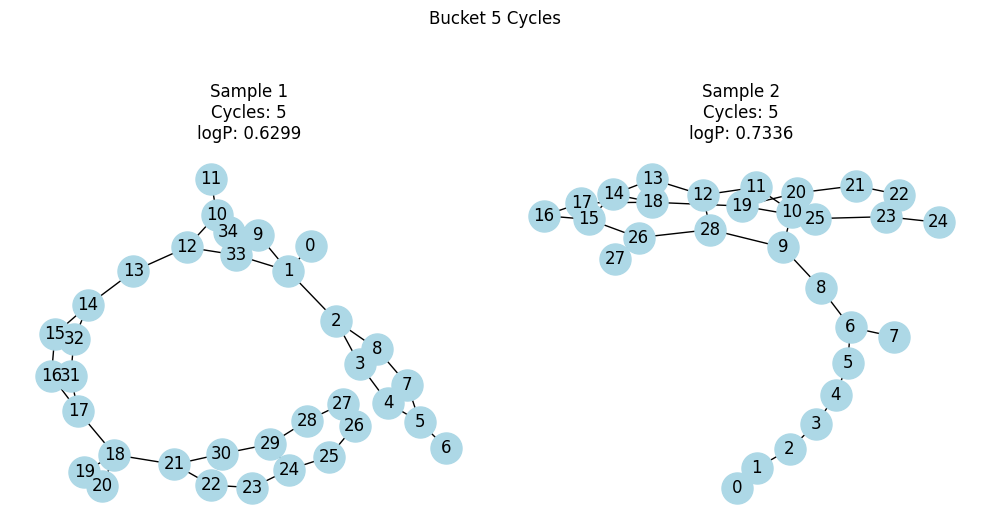


Bucket 5:
Number of graphs: 36
Average logP: 0.3154
--------------------------------------------------


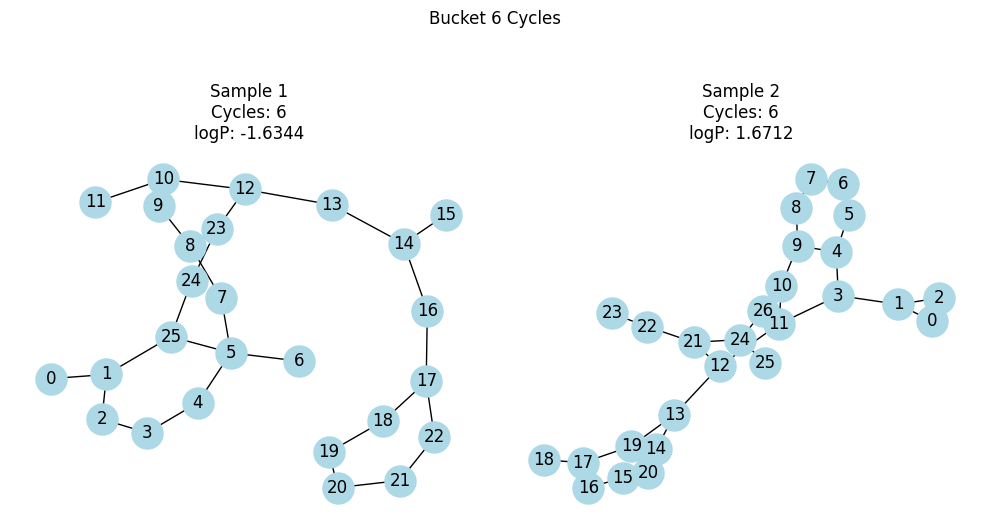


Bucket 6:
Number of graphs: 14
Average logP: -0.9934
--------------------------------------------------


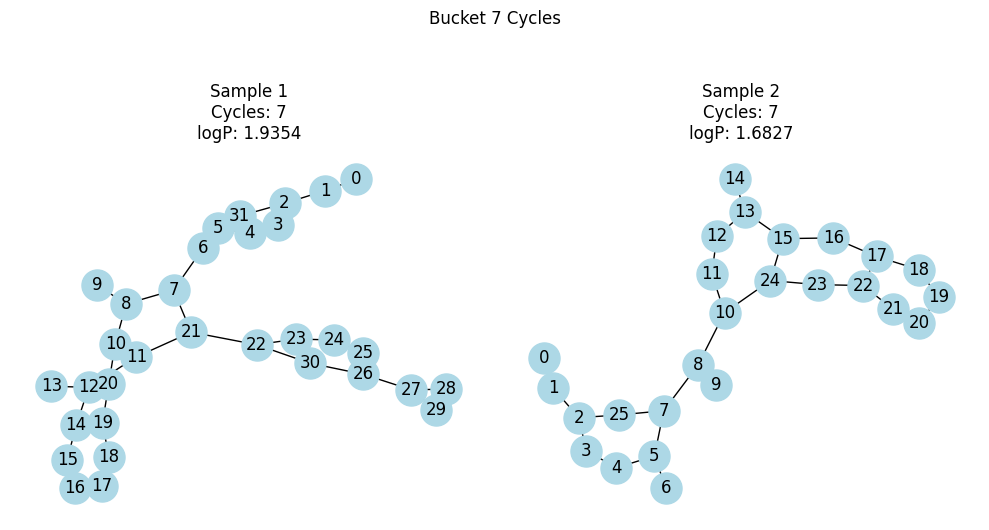


Bucket 7:
Number of graphs: 6
Average logP: -2.8711
--------------------------------------------------


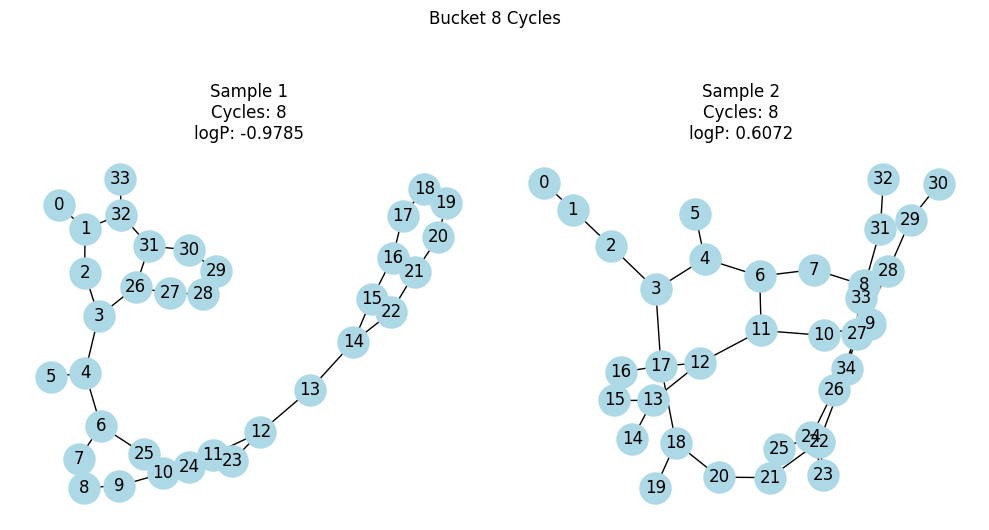


Bucket 8:
Number of graphs: 7
Average logP: -1.2341
--------------------------------------------------


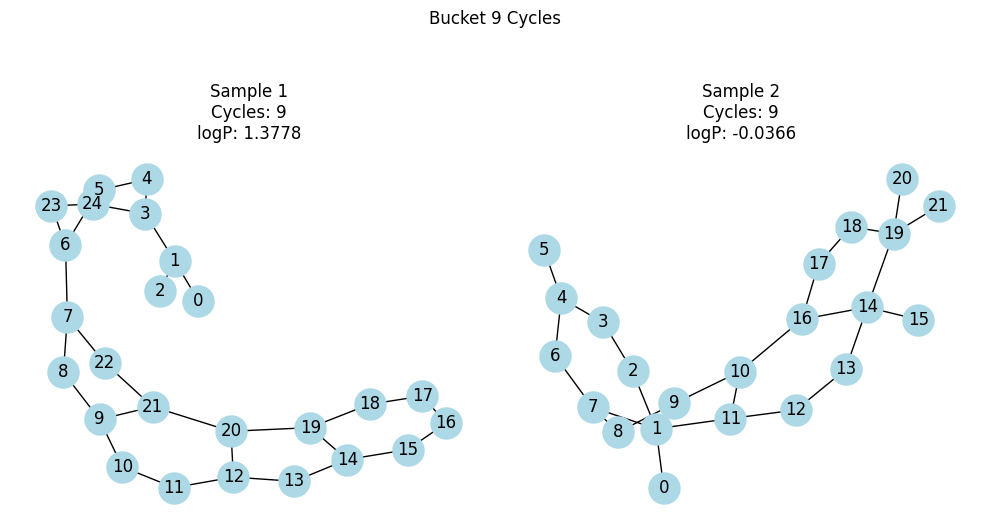


Bucket 9:
Number of graphs: 2
Average logP: 0.6706
--------------------------------------------------


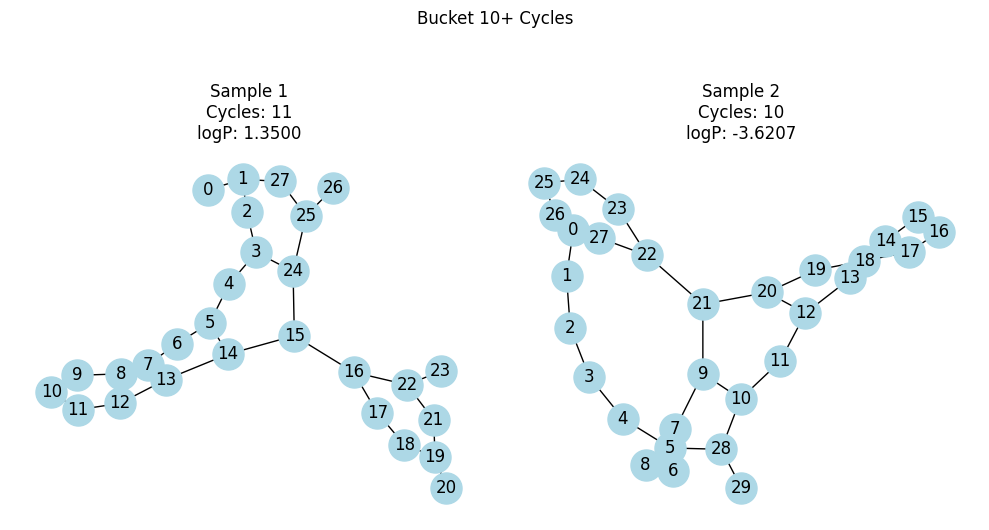


Bucket 10+:
Number of graphs: 4
Average logP: -3.1790
--------------------------------------------------


In [7]:
def visualize_bucket_samples(dataset, num_samples_per_bucket=2):
    """Visualize sample graphs from each cycle bucket."""
    # Create buckets
    cycle_buckets = {i: [] for i in range(11)}  # 0-9 cycles, and 10+ cycles
    
    # Sort graphs into buckets
    for i, graph_data in enumerate(dataset):
        G = to_networkx(graph_data, to_undirected=True)
        cycles = [cycle for cycle in nx.simple_cycles(G) if len(cycle) >= 6]
        num_cycles = len(cycles)
        bucket = min(num_cycles, 10)
        cycle_buckets[bucket].append((graph_data, G, cycles))
    
    # Create visualization for each bucket that has graphs
    for bucket in range(11):
        if len(cycle_buckets[bucket]) > 0:
            # Create figure with subplots for each sample
            n_samples = min(num_samples_per_bucket, len(cycle_buckets[bucket]))
            fig, axes = plt.subplots(1, n_samples, figsize=(5*n_samples, 5))
            if n_samples == 1:
                axes = [axes]
            
            # Plot each sample
            for i in range(n_samples):
                data, G, cycles = cycle_buckets[bucket][i]
                pos = nx.spring_layout(G)
                nx.draw(G, pos, with_labels=True, node_color='lightblue', 
                       node_size=500, ax=axes[i])
                axes[i].set_title(f'Sample {i+1}\nCycles: {len(cycles)}\nlogP: {data.y.item():.4f}')
            
            plt.suptitle(f'Bucket {bucket if bucket < 10 else "10+"} Cycles', y=1.05)
            plt.tight_layout()
            plt.show()
            
            # Print bucket statistics
            print(f"\nBucket {bucket if bucket < 10 else '10+'}:")
            print(f"Number of graphs: {len(cycle_buckets[bucket])}")
            print(f"Average logP: {np.mean([data.y.item() for data, _, _ in cycle_buckets[bucket]]):.4f}")
            print("-" * 50)

# Use the function
visualize_bucket_samples(val_dataset)